In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Step 1: Load Data
file_path = 'encoded_resampled_dataset.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Step 2: Separate Features and Targets
X = data.drop(columns=['clarity', 'color', 'cut'])  # Features
Y = data[['clarity', 'color', 'cut']]  # Multi-label targets

# Step 3: Convert Multi-Label Targets to Single-Label
Y = Y.values.argmax(axis=1)  # Convert to single-label multi-class by `argmax`

# Step 4: Split Data into Training, Validation, and Test Sets
X_train, X_temp, Y_train, Y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=42, stratify=Y
)
X_val, X_test, Y_val, Y_test = train_test_split(
    X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp
)

# Step 5: Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Step 6: Apply PCA (retain 95% variance)
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 7: Define Hyperparameter Grid for GridSearchCV (with different approach)
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Step 8: GridSearchCV for Hyperparameter Tuning (using GridSearchCV here)
rf_model = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='f1_macro',  # Use F1 score for multi-class classification
    n_jobs=-1,
    verbose=2  # To get more detailed output during fitting
)

# Step 9: Fit the GridSearchCV to the training data
grid_search.fit(X_train_pca, Y_train)

# Best parameters and score
print("Best Parameters from GridSearchCV:", grid_search.best_params_)
print("Best F1-Score on Training Data:", grid_search.best_score_)

# Step 10: Use the best estimator from GridSearchCV
best_rf_model = grid_search.best_estimator_

# Step 11: Predictions on Train, Validation, and Test Sets (using the best model)
train_preds = best_rf_model.predict(X_train_pca)
val_preds = best_rf_model.predict(X_val_pca)
test_preds = best_rf_model.predict(X_test_pca)

# Step 12: Evaluate the Tuned Model with F1-score, Accuracy, Precision, and Recall
train_f1 = f1_score(Y_train, train_preds, average='macro', zero_division=1)
val_f1 = f1_score(Y_val, val_preds, average='macro', zero_division=1)
test_f1 = f1_score(Y_test, test_preds, average='macro', zero_division=1)

train_accuracy = accuracy_score(Y_train, train_preds)
val_accuracy = accuracy_score(Y_val, val_preds)
test_accuracy = accuracy_score(Y_test, test_preds)

train_precision = precision_score(Y_train, train_preds, average='macro', zero_division=1)
val_precision = precision_score(Y_val, val_preds, average='macro', zero_division=1)
test_precision = precision_score(Y_test, test_preds, average='macro', zero_division=1)

train_recall = recall_score(Y_train, train_preds, average='macro', zero_division=1)
val_recall = recall_score(Y_val, val_preds, average='macro', zero_division=1)
test_recall = recall_score(Y_test, test_preds, average='macro', zero_division=1)

# Step 13: Print Tuned Model Results
print("\nTuned Random Forest Results")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Train F1-Score: {train_f1:.4f}")
print(f"Validation F1-Score: {val_f1:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Test Recall: {test_recall:.4f}")


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters from GridSearchCV: {'bootstrap': False, 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1-Score on Training Data: 0.7995344144220713

Tuned Random Forest Results
Train Accuracy: 0.9887
Validation Accuracy: 0.9787
Test Accuracy: 0.9773
Train F1-Score: 0.9292
Validation F1-Score: 0.8030
Test F1-Score: 0.7981
Train Precision: 0.9954
Validation Precision: 0.8868
Test Precision: 0.9035
Train Recall: 0.8793
Validation Recall: 0.7422
Test Recall: 0.7282


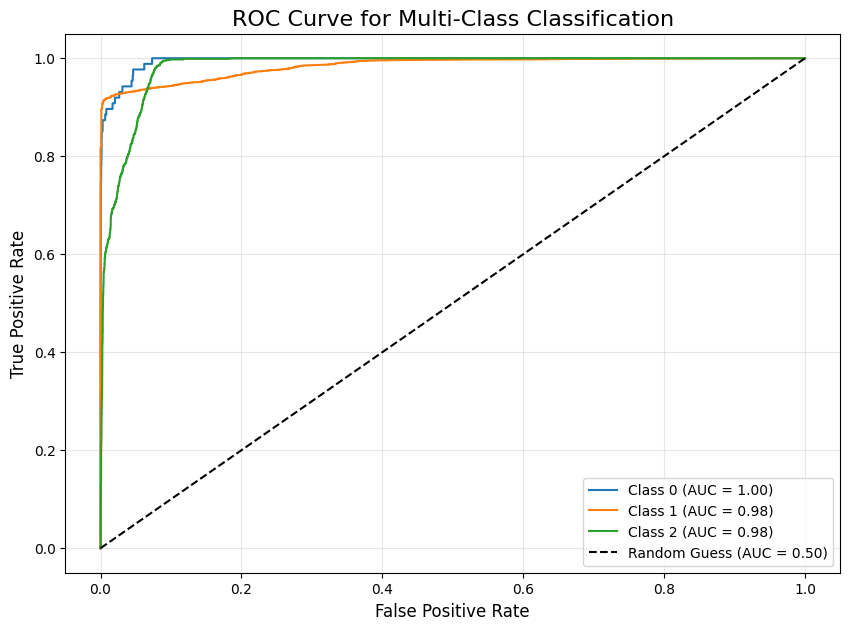

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
import seaborn as sns

# Step 1: Binarize the labels for ROC curve (One-vs-Rest strategy)
classes = np.unique(Y_train)
Y_test_bin = label_binarize(Y_test, classes=classes)
test_preds_prob = best_rf_model.predict_proba(X_test_pca)  # Get predicted probabilities

# Step 2: Compute ROC Curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i, class_label in enumerate(classes):
    fpr[class_label], tpr[class_label], _ = roc_curve(Y_test_bin[:, i], test_preds_prob[:, i])
    roc_auc[class_label] = auc(fpr[class_label], tpr[class_label])

# Step 3: Plot ROC Curve
plt.figure(figsize=(10, 7))
for class_label in classes:
    plt.plot(
        fpr[class_label],
        tpr[class_label],
        label=f"Class {class_label} (AUC = {roc_auc[class_label]:.2f})"
    )

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.50)')
plt.title("ROC Curve for Multi-Class Classification", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()



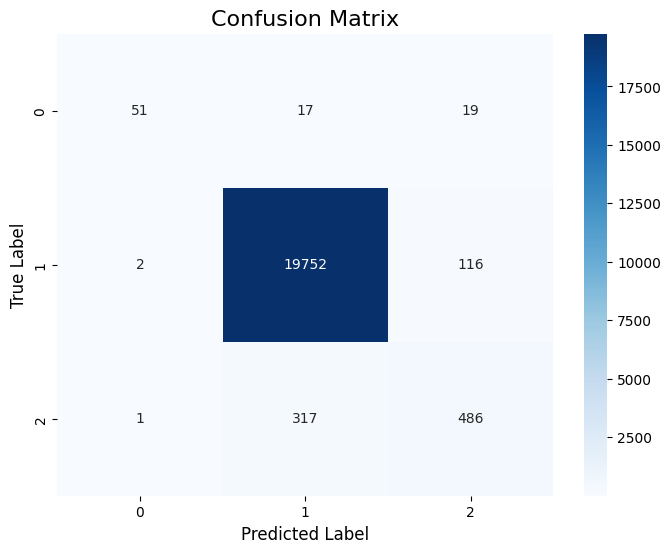

In [17]:

# Step 4: Confusion Matrix
conf_matrix = confusion_matrix(Y_test, test_preds, labels=classes)

# Step 5: Plot Confusion Matrix as Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()


In [16]:
# Check the mapping of classes
unique_combinations = data[['clarity', 'color', 'cut']].drop_duplicates()
print(unique_combinations)


        clarity  color  cut
0             3      0    9
1             3      8    7
2             2      2    7
3             0      0   12
5             3      0    7
...         ...    ...  ...
107545        0     21   11
110652        0     22   11
115524        0     23   11
123986        0     25   12
126826        0     25   13

[471 rows x 3 columns]
